In [310]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import lazypredict
from lazypredict.Supervised import LazyClassifier


ModuleNotFoundError: No module named 'lazypredict'

<h3>1. Loading Data / Basic Info<h3>

In [ ]:
og_df = pd.read_csv('Data/healthcare-dataset-stroke-data.csv')
og_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
for col in og_df.columns:
    if og_df[col].dtype == "object":
        print(og_df[col].value_counts())
        print("\n")
        
for col in og_df.columns:
    if og_df[col].dtype == "int64" and col != "id":
        print(og_df[col].value_counts())
        print("\n")


Female    2994
Male      2115
Other        1
Name: gender, dtype: int64


Yes    3353
No     1757
Name: ever_married, dtype: int64


Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64


Urban    2596
Rural    2514
Name: Residence_type, dtype: int64


never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64


0    4612
1     498
Name: hypertension, dtype: int64


0    4834
1     276
Name: heart_disease, dtype: int64


0    4861
1     249
Name: stroke, dtype: int64




In [ ]:
og_df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

<h3>3. Pre-Visualization Data Cleanup<h3>

In [ ]:
main_df = og_df

#removed the gender "Other" from the dataset since it only has 1 entry
other_index = main_df.index[main_df["gender"] == "Other"]
main_df = main_df.drop(other_index)

#removed the "id" column since it is not needed
main_df = main_df.drop(columns=["id"])


features_train, features_test, target_train, target_test = train_test_split(main_df.drop(columns=["stroke"]), main_df["stroke"], test_size=0.2, random_state=42, stratify = main_df["stroke"])


#replaced NaN values in the "bmi" column with the average value of the column
average_bmi = features_train["bmi"].mean()
features_train["bmi"].fillna(average_bmi, inplace=True)
features_test["bmi"].fillna(average_bmi, inplace=True)


#categorized ages into age groups
bins = [0, 13, 20, 40, 60, 120]
labels = ["Children", "Teenagers", "Young Adults", "Middle-aged Adults", "Seniors"]
main_df["age_group"] = pd.cut(main_df["age"], bins=bins, labels=labels, right=False)

features_train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
845,Female,48.0,0,0,Yes,Private,Urban,69.21,33.1,never smoked
3745,Female,29.0,0,0,No,Private,Urban,84.19,21.2,never smoked
4184,Female,35.0,0,0,Yes,Private,Rural,119.40,22.9,never smoked
3410,Male,38.0,0,0,Yes,Private,Rural,108.68,32.7,never smoked
284,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown


<h3>4. Visualization<h3>

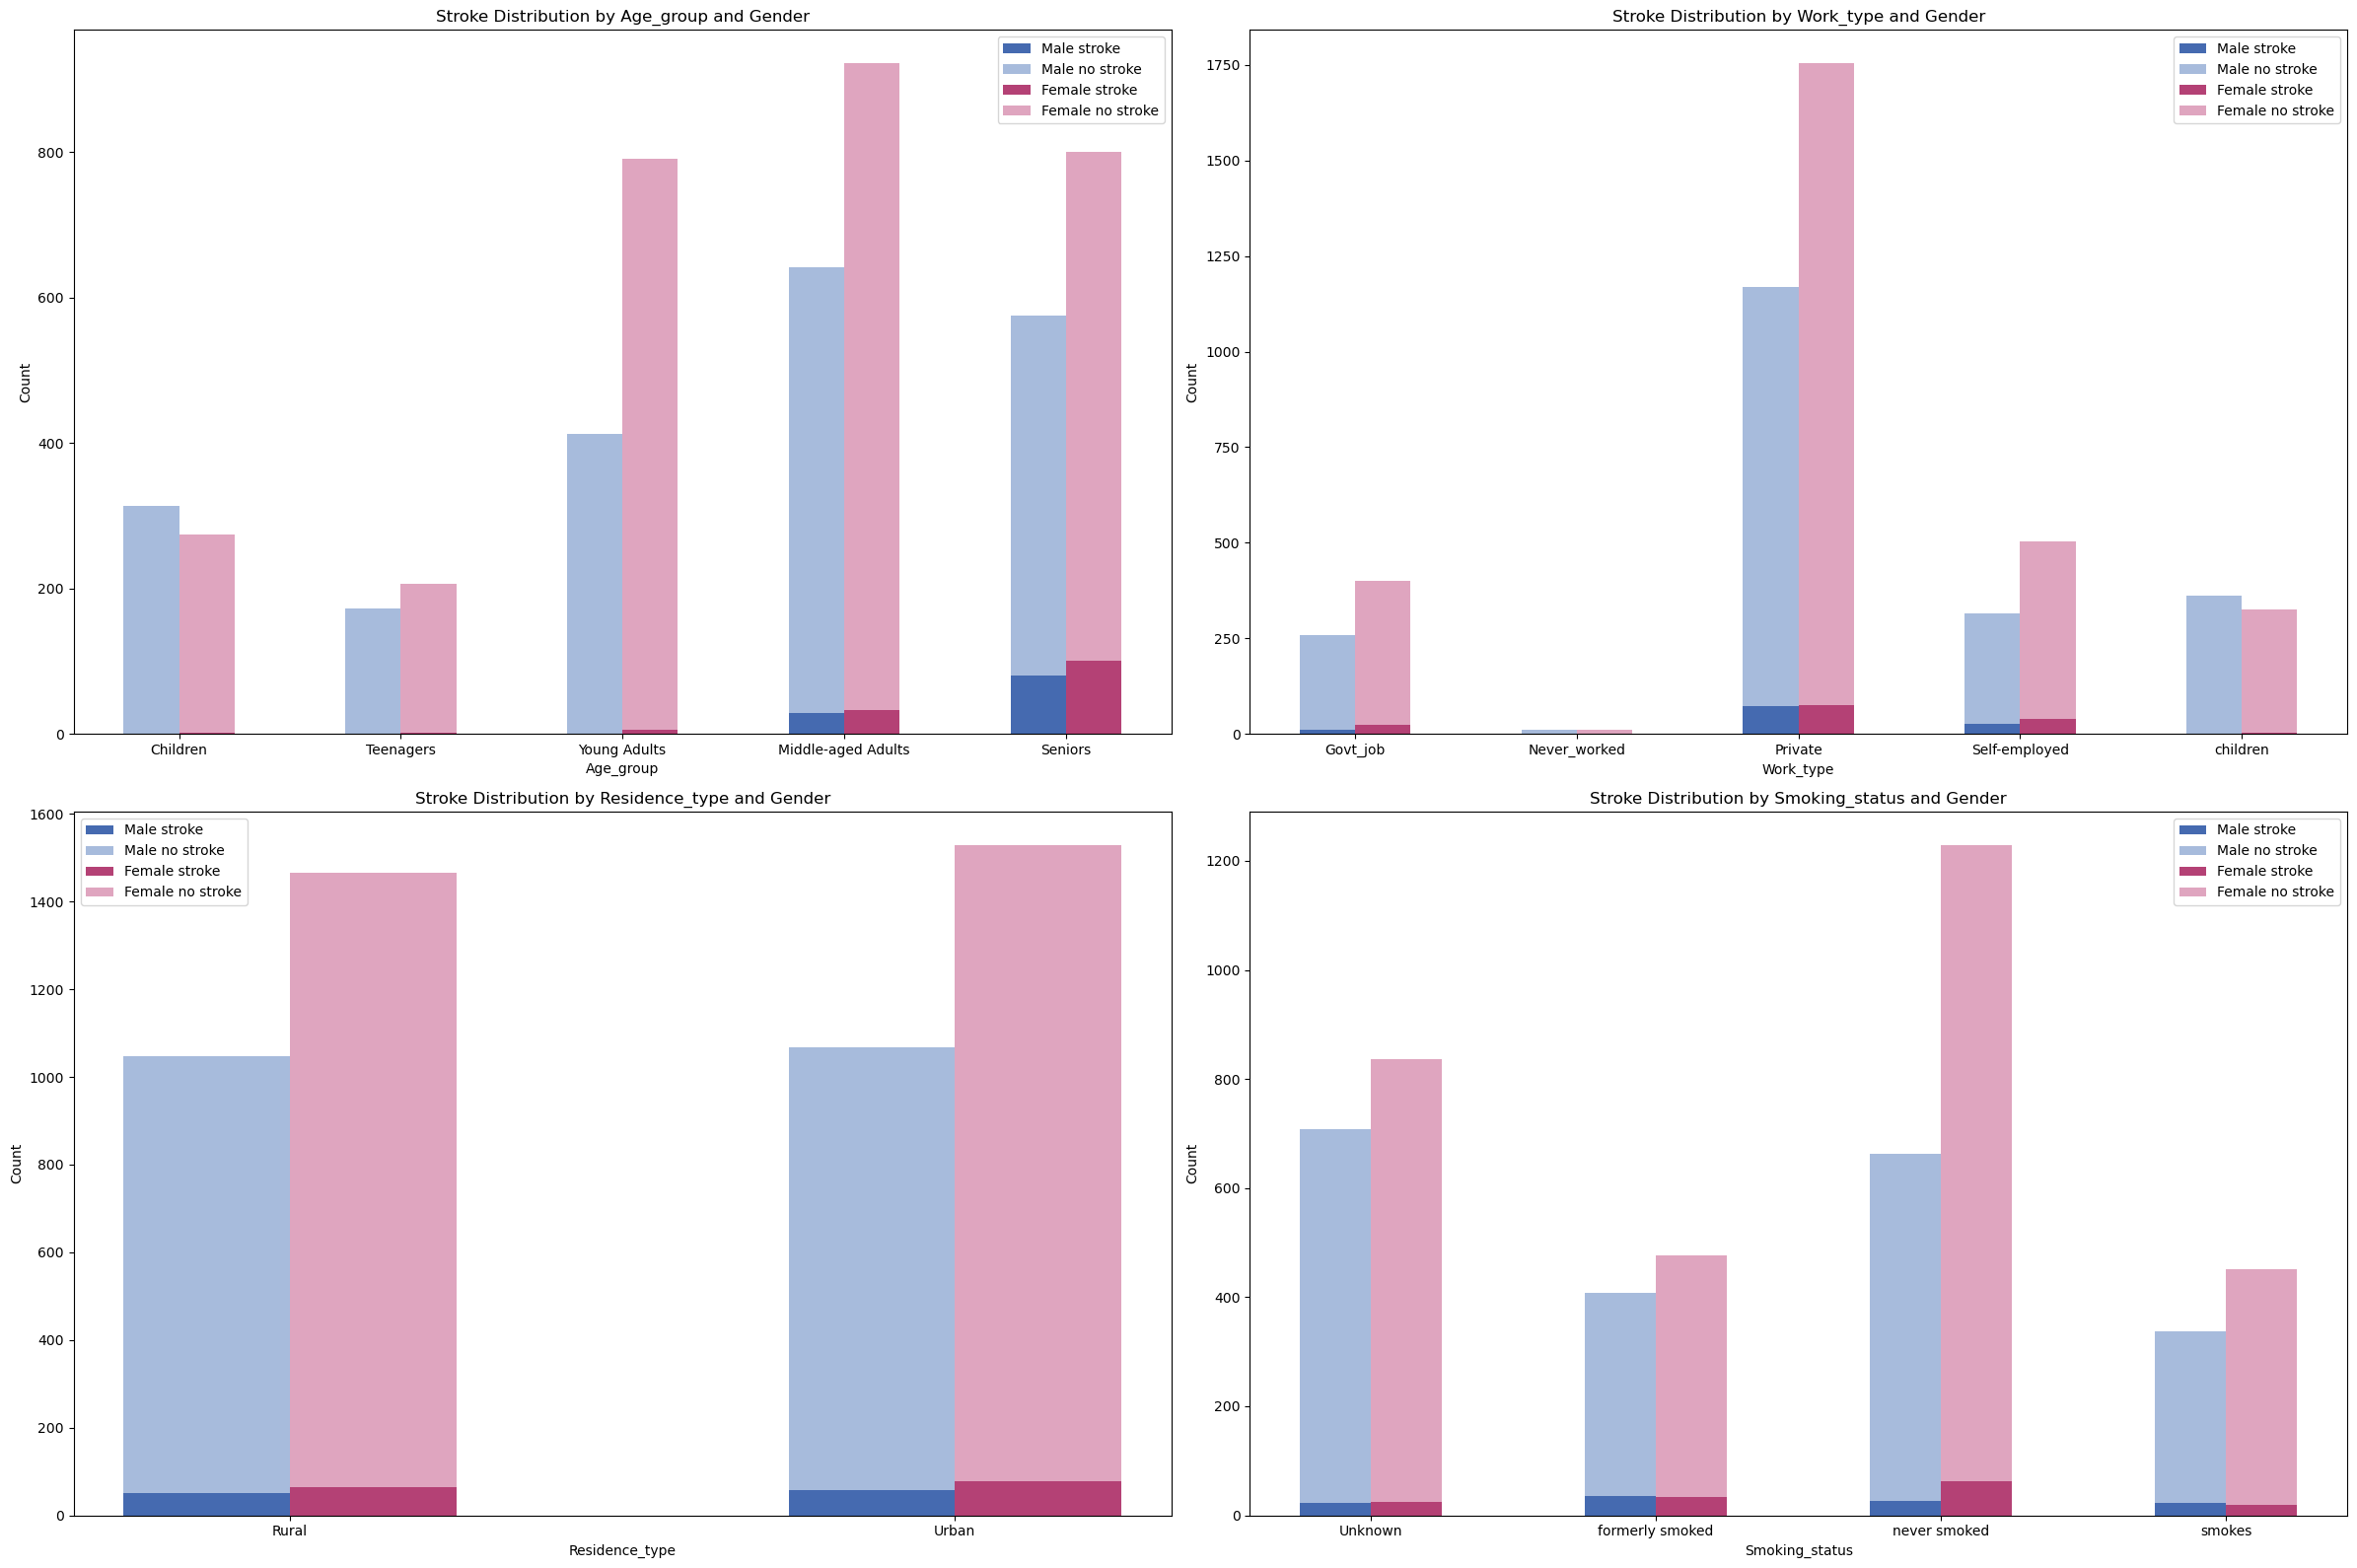

In [ ]:
# List of variables to group by
group_vars = ["age_group", "work_type", "Residence_type", "smoking_status"]

# Create 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(24, 16))

# Flatten axs to make it easier to iterate over
axs = axs.flatten()

# Set width of bar
barWidth = 0.25



# Iterate over group_vars and axs simultaneously
for var, ax in zip(group_vars, axs):
    # Group by var, "gender" and "stroke" and get the size of each group
    grouped = main_df.groupby([var, "gender", "stroke"]).size().unstack(level=[1, 2], fill_value=0)
    
    # Set position of bar on X axis
    r1 = np.arange(len(grouped.index))
    r2 = [x + barWidth for x in r1]

    # Create bars for each group
    for i, gender in enumerate(["Male", "Female"]):
        r = r1 if gender == "Male" else r2
        ax.bar(
            r, 
            grouped[(gender, 1)], 
            color="#456AB0" if gender == "Male" else "#B44175",
            width=barWidth,
            label=f"{gender} stroke"
        )
        ax.bar(
            r, 
            grouped[(gender, 0)], 
            bottom=grouped[(gender, 1)], 
            color="#A7BBDC" if gender == "Male" else "#DFA5BF", 
            width=barWidth,
            label=f"{gender} no stroke"
        )

    # Plot chart
    ax.set_xticks([r + barWidth/2 for r in range(len(grouped.index))])
    ax.set_xticklabels(grouped.index.astype(str))
    ax.legend()
    ax.set_xlabel(var.capitalize())
    ax.set_ylabel("Count")
    ax.set_title(f"Stroke Distribution by {var.capitalize()} and Gender")

# Display plots
plt.tight_layout()
plt.show()

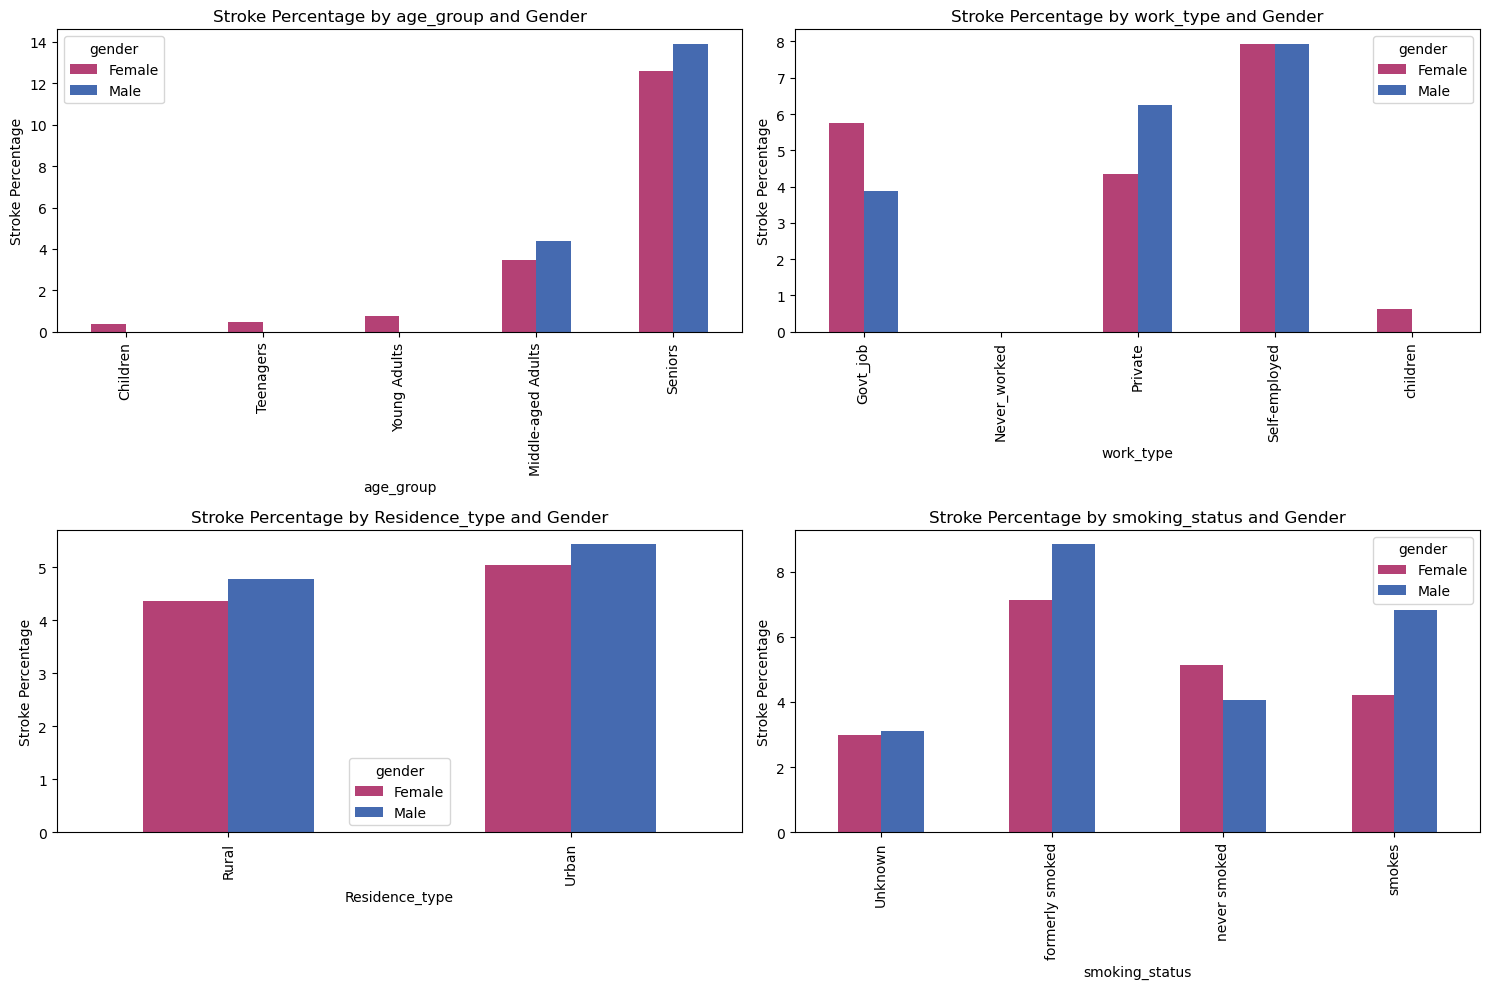

In [ ]:
variables = ["age_group", "work_type", "Residence_type", "smoking_status"]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, var in enumerate(variables):
    ax = axs[i//2, i%2]
    grouped = main_df.groupby([var, "gender"])
    total = grouped.size()
    stroke_cases = grouped['stroke'].sum()
    stroke_percentage = (stroke_cases / total) * 100
    result = stroke_percentage.reset_index(name='stroke_percentage')
    
    result.pivot(index=var, columns="gender", values="stroke_percentage").plot(kind='bar', ax=ax, color=["#B44175", "#456AB0"])
    ax.set_title(f'Stroke Percentage by {var} and Gender')
    ax.set_ylabel('Stroke Percentage')

plt.tight_layout()
plt.show()

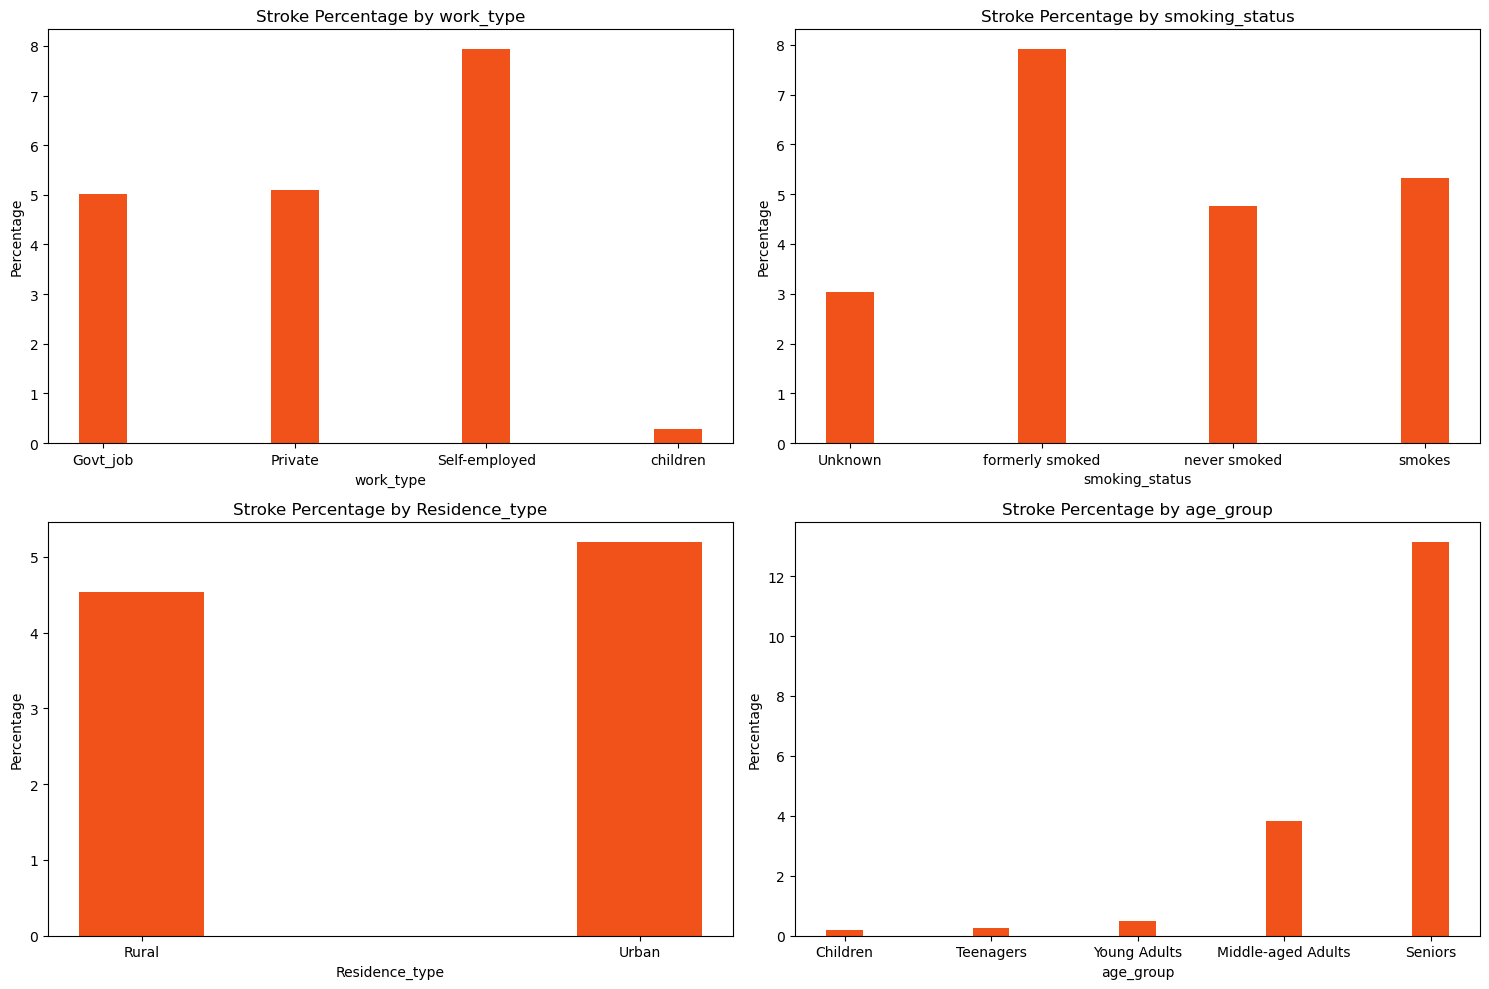

In [ ]:
def calculate_percentage(main_df, column):
    group = main_df.groupby(column)['stroke'].value_counts(normalize=True).mul(100).rename('percentage').reset_index()
    stroke_percentage = group[group['stroke'] == 1]
    return stroke_percentage

work_type_percentage = calculate_percentage(main_df, 'work_type')
smoking_status_percentage = calculate_percentage(main_df, 'smoking_status')
residence_type_percentage = calculate_percentage(main_df, 'Residence_type')
age_group_percentage = calculate_percentage(main_df, 'age_group')

def plot_percentage(dfs, columns):
    fig, axs = plt.subplots(2, 2, figsize=(15,10))
    axs = axs.ravel()

    for i in range(4):
        axs[i].bar(dfs[i][columns[i]], dfs[i]['percentage'], color=["#F05219"], width=0.25)
        axs[i].set_xlabel(columns[i])
        axs[i].set_ylabel('Percentage')
        axs[i].set_title(f'Stroke Percentage by {columns[i]}')

    plt.tight_layout()
    plt.show()

plot_percentage([work_type_percentage, smoking_status_percentage, residence_type_percentage, age_group_percentage], 
                ['work_type', 'smoking_status', 'Residence_type', 'age_group'])

<h3>5. Pre-Processing<h3>

<h4>5.1 Normalization<h4>

In [ ]:
pt = PowerTransformer(method='box-cox', standardize=False, copy=False)

features_train[["bmi", "avg_glucose_level", "age"]] = pt.fit_transform(features_train[["bmi", "avg_glucose_level", "age"]])
features_test[["bmi", "avg_glucose_level", "age"]] = pt.transform(features_test[["bmi", "avg_glucose_level", "age"]])


Text(0.5, 1.0, 'Stroke: No')

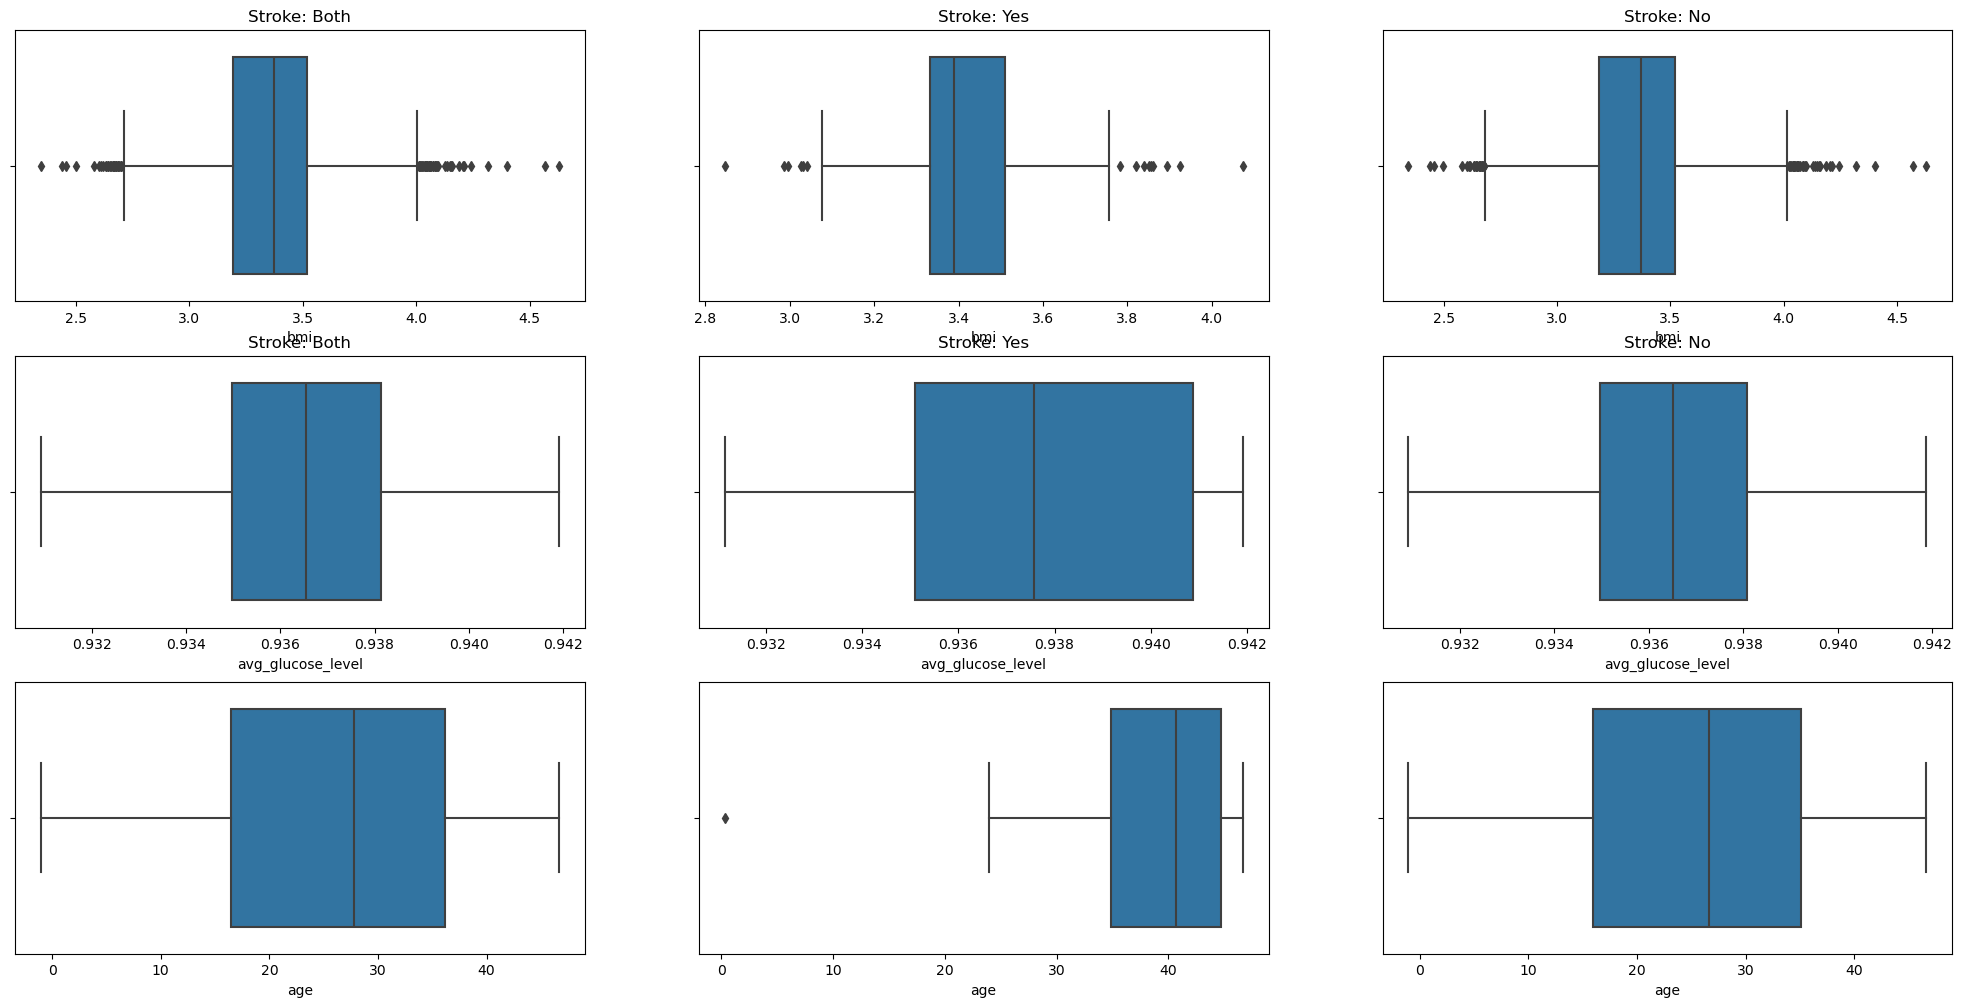

In [ ]:
plot_norm = pd.concat([features_train, target_train], axis=1)

stroke_yes = plot_norm[plot_norm['stroke'] == 1]
stroke_no = plot_norm[plot_norm['stroke'] == 0]

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(25, 12))	

sns.boxplot(x=plot_norm['bmi'], ax=ax[0,0])
ax[0,0].set_title('Stroke: Both')

sns.boxplot(x=stroke_yes['bmi'], ax=ax[0,1])
ax[0,1].set_title('Stroke: Yes')

sns.boxplot(x=stroke_no['bmi'], ax=ax[0,2])
ax[0,2].set_title('Stroke: No')

sns.boxplot(x=plot_norm['avg_glucose_level'], ax=ax[1,0])
ax[1,0].set_title('Stroke: Both')

sns.boxplot(x=stroke_yes['avg_glucose_level'], ax=ax[1,1])
ax[1,1].set_title('Stroke: Yes')

sns.boxplot(x=stroke_no['avg_glucose_level'], ax=ax[1,2])
ax[1,2].set_title('Stroke: No')

sns.boxplot(x=plot_norm['age'], ax=ax[2,0])
ax[1,0].set_title('Stroke: Both')

sns.boxplot(x=stroke_yes['age'], ax=ax[2,1])
ax[1,1].set_title('Stroke: Yes')

sns.boxplot(x=stroke_no['age'], ax=ax[2,2])
ax[1,2].set_title('Stroke: No')

<h4>5.2 Label Encoding<h4>

In [ ]:
le = LabelEncoder()
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
l3 = []; l4 = []
print('Label Encoder Transformation')
for i in categorical_cols:
    features_train[i] = le.fit_transform(features_train[i])
    features_test[i] = le.transform(features_test[i])
    
    l3.append(list(features_train[i].unique())); l4.append(list(le.inverse_transform(features_train[i].unique())))
    print(i,' : ',features_train[i].unique(),' = ',le.inverse_transform(features_train[i].unique()))

Label Encoder Transformation
gender  :  [0 1]  =  ['Female' 'Male']
ever_married  :  [1 0]  =  ['Yes' 'No']
work_type  :  [2 0 4 3 1]  =  ['Private' 'Govt_job' 'children' 'Self-employed' 'Never_worked']
Residence_type  :  [1 0]  =  ['Urban' 'Rural']
smoking_status  :  [2 0 1 3]  =  ['never smoked' 'Unknown' 'formerly smoked' 'smokes']


<h4>5.3 Balancing<h4>

In [ ]:
under_sampler = RandomUnderSampler(sampling_strategy=0.075)
smote = SMOTE(sampling_strategy=1)


features_under, target_under = under_sampler.fit_resample(features_train, target_train)

features_balanced, target_balanced = smote.fit_resample(features_under, target_under)

Counter(target_balanced)


Counter({0: 2653, 1: 2653})

In [ ]:
target_balanced.value_counts()

0    2653
1    2653
Name: stroke, dtype: int64

In [ ]:
target_test.value_counts()

0    972
1     50
Name: stroke, dtype: int64

In [ ]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

models, predictions = clf.fit(features_balanced, features_test, target_balanced, target_test)

NameError: name 'LazyClassifier' is not defined